## Customer Segmentation using K-Means Clustering

The dateset used in this Cluster Analysis can be found <a href="https://www.kaggle.com/vijayuv/onlineretail">here</a>

The steps taken in this project are:
* **Data Cleaning**
* **Create RFM Table**
* **Manage Skew**
* **Standardize Variables**
* **Clustering - using KMeans**
For each variable R/F/M
    - Plot Screeplot
    - Silhouette score
    - Clustering - assign clusters for each of RFM
* **Segmenting Customers**
Identify Cluster characteristics and segment into
    - New Customers
    - Non Returning Customers
    - Low Value Customers
    - Mid Value Customers
    - High Value Customers
* **Segment Visualization**
* **Segment Analysis**
* **Conclusion on KMeans**


---

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('OnlineRetail.csv',  encoding= 'unicode_escape')

In [3]:
df.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
309325,564079,21928,JUMBO BAG SCANDINAVIAN BLUE PAISLEY,10,22-08-2011 15:55,2.08,12627.0,Germany
311846,564323,22386,JUMBO BAG PINK POLKADOT,100,24-08-2011 13:24,1.75,13694.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## Data Cleaning

In [6]:
df.isnull().values.any()

True

In [7]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

#### Removing entries with null CustomerID

In [8]:
df = df[df['CustomerID'].notna()] #df[df['CustomerID'].isna()]
df.shape

(406829, 8)

#### Change InvoiceDate to date dataype

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

#### Check if quantity is positive value else remove

In [10]:
df[df['Quantity']<=0].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
225434,C556678,23064,CINDERELLA CHANDELIER,-4,2011-06-13 17:21:00,41.75,13658.0,United Kingdom
146991,C549041,21156,RETROSPOT CHILDRENS APRON,-8,2011-05-04 17:22:00,1.95,17644.0,United Kingdom


In [11]:
df = df[df['Quantity']>0]

#### Calculate TotalPrice from Quantity and UnitPrice

In [12]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
419992,572866,20723,STRAWBERRY CHARLOTTE BAG,3,2011-10-26 13:07:00,0.85,15005.0,United Kingdom,2.55
241214,558195,21213,PACK OF 72 SKULL CAKE CASES,24,2011-06-27 12:32:00,0.55,17735.0,United Kingdom,13.20


## Create Recency Frequency Monetary value Table

In [13]:
import datetime
snapshot_date = max(df['InvoiceDate']) + datetime.timedelta(days=1)
snapshot_date

#Aggregate by CustomerID
customers = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x:(snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

customers.rename(columns= {'InvoiceDate' : 'Recency',
                          'InvoiceNo' : 'Frequency',
                          'TotalPrice' : 'Monetary'}, inplace=True)
customers.sample(2)

,Recency,Frequency,Monetary
CustomerID,,,
16943.0,6,33,816.73
15125.0,27,127,11528.48


## Manage Skew

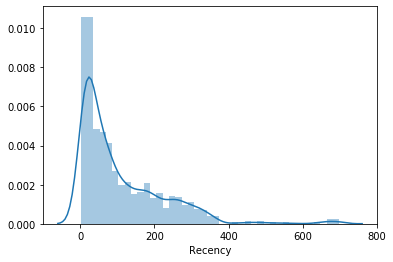

In [14]:
#Visualization of each variable
sns.distplot(customers.Recency)

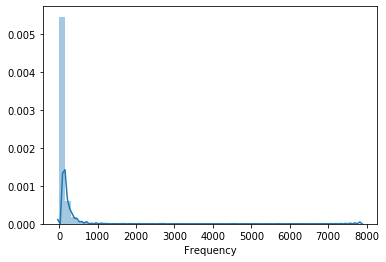

In [15]:
sns.distplot(customers.Frequency)

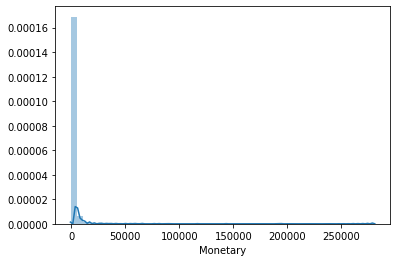

In [16]:
sns.distplot(customers.Monetary)

#### Highly skewed distribution is observed for all three variables, this can be rectified by applying one of the transformations on the data.
 - Log Transformation
 - SquareRoot Transformation
 - Cube Transformation
 - Box-Cox Transformation

In [17]:
#Skew Values on the variables
print(customers.Recency.skew())
print(customers.Frequency.skew())
print(customers.Monetary.skew())

1.9175159984488952
18.106242903118684
19.326985305561827


#### Log Transformation

-0.6547244680673008
-0.22015490308024482
nan


/Users/haripriya/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


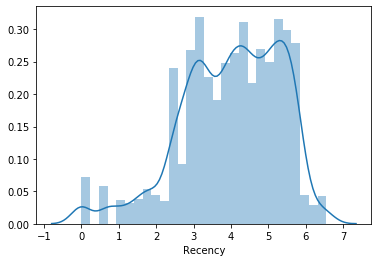

In [18]:
recency_log = np.log(customers.Recency)
frequency_log = np.log(customers.Frequency)
monetary_log = np.log(customers.Monetary)
print(recency_log.skew())
print(frequency_log.skew())
print(monetary_log.skew())
sns.distplot(recency_log)

#### Square Root Transformation

0.6969867632799238
3.2228655181183483
5.886428106945661


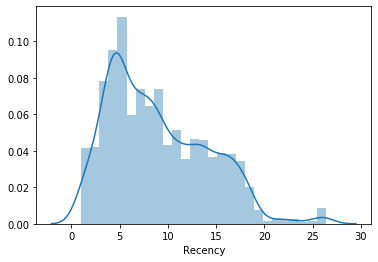

In [19]:
recency_sqrt = np.sqrt(customers.Recency)
frequency_sqrt = np.sqrt(customers.Frequency)
monetary_sqrt = np.sqrt(customers.Monetary)
print(recency_sqrt.skew())
print(frequency_sqrt.skew())
print(monetary_sqrt.skew())
sns.distplot(recency_sqrt)

#### Cube Root Transformation

0.31240733935389847
1.5139956026003647
2.996715482799713


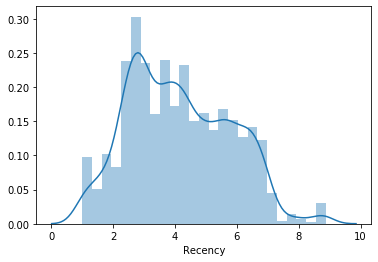

In [20]:
recency_cbrt = np.cbrt(customers.Recency)
frequency_cbrt = np.cbrt(customers.Frequency)
monetary_cbrt = np.cbrt(customers.Monetary)
print(recency_cbrt.skew())
print(frequency_cbrt.skew())
print(monetary_cbrt.skew())
sns.distplot(recency_cbrt)

-0.05129871179645878
0.004197415222226033


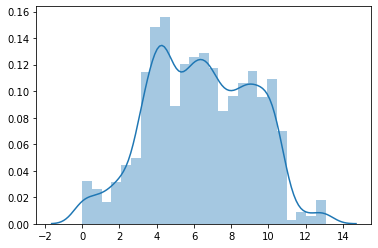

In [21]:
from scipy import stats
recency_boxcox = stats.boxcox(customers.Recency)[0]
frequency_boxcox = stats.boxcox(customers.Frequency)[0]
print(pd.Series(recency_boxcox).skew())
print(pd.Series(frequency_boxcox).skew())
sns.distplot(recency_boxcox)

#### Observations:
- Monetary value data is not positive, hence CubeRoot Transformation is used for it
- BoxCox Transformation shows least skew(nearer to zero) for Recency and Frequency 

In [22]:
customers_fix = pd.DataFrame()
customers_fix['CustomerID'] = customers.index
customers_fix['Recency'] = stats.boxcox(customers.Recency)[0]
customers_fix['Frequency'] = stats.boxcox(customers.Frequency)[0]
customers_fix['Monetary'] = pd.Series(np.cbrt(customers['Monetary'])).values
customers_fix

,CustomerID,Recency,Frequency,Monetary
0,12346.0,10.594460,0.000000,42.576995
1,12347.0,5.408713,5.973859,16.273929
2,12348.0,6.771296,3.758729,12.158183
3,12349.0,4.044175,4.805208,12.068017
4,12350.0,10.453001,3.051922,6.941001
...,...,...,...,...
4334,18280.0,8.589243,2.445694,5.652483
4335,18281.0,1.884613,2.047477,4.323541
4336,18282.0,9.400988,2.652113,5.625753
4337,18283.0,3.042330,7.909634,12.795376


## Standardize the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix)
customers_normalised = scaler.transform(customers_fix)
customers_normalised

customers_normalised = pd.DataFrame()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customers_fix['Recency'])
customers_normalised['Recency'] = scaler.transform(customers_fix['Recency'])
customers_normalised

In [23]:
from sklearn import preprocessing
customers_scaled = pd.DataFrame()
customers_scaled['CustomerID'] = customers_fix['CustomerID']
customers_scaled['Recency'] = preprocessing.scale(customers_fix['Recency'])
customers_scaled['Frequency'] = preprocessing.scale(customers_fix['Frequency'])
customers_scaled['Monetary'] = preprocessing.scale(customers_fix['Monetary'])
customers_scaled

,CustomerID,Recency,Frequency,Monetary
0,12346.0,1.543469,-2.568435,6.608337
1,12347.0,-0.343482,1.166124,1.291771
2,12348.0,0.152324,-0.218665,0.459867
3,12349.0,-0.840000,0.435542,0.441642
4,12350.0,1.491995,-0.660525,-0.594668
...,...,...,...,...
4334,18280.0,0.813825,-1.039509,-0.855112
4335,18281.0,-1.625805,-1.288454,-1.123727
4336,18282.0,1.109197,-0.910466,-0.860515
4337,18283.0,-1.204544,2.376274,0.588661


---

# CLUSTERING - K means

---

## Recency

#### Elbow Method

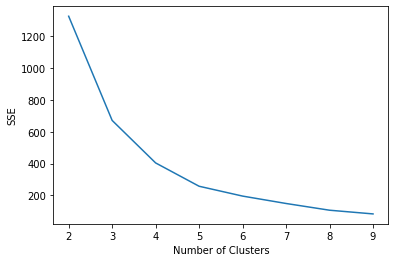

In [24]:
from sklearn import cluster
sse={}

df_recency = customers_scaled[['Recency']].values

for k in range(2,10):
    model = cluster.KMeans(n_clusters=k, random_state=3)
    model.fit_predict(df_recency)
    sse[k] = model.inertia_
    
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()


#### Silhouette Score

In [25]:
from sklearn.metrics import silhouette_score

for k in [3,4,5,6]:
    kmeans = cluster.KMeans(n_clusters=k).fit(df_recency)
    silhouette_avg = silhouette_score(df_recency, kmeans.labels_)
    print('Silhouettescore for %i Clusters: %0.4f' %(k, silhouette_avg))

Silhouettescore for 3 Clusters: 0.5664
Silhouettescore for 4 Clusters: 0.5786
Silhouettescore for 5 Clusters: 0.5684
Silhouettescore for 6 Clusters: 0.5418


- 4 clusters has the highest silhouette score so we will choose 4 clusters

#### Assigning Recency Clusters

In [26]:
kmeans = cluster.KMeans(n_clusters=4).fit(customers_scaled[['Recency']].values)
customers_scaled['RecencyCluster'] = kmeans.labels_
customers_scaled.head(5)

,CustomerID,Recency,Frequency,Monetary,RecencyCluster
0,12346.0,1.543469,-2.568435,6.608337,1
1,12347.0,-0.343482,1.166124,1.291771,2
2,12348.0,0.152324,-0.218665,0.459867,0
3,12349.0,-0.840000,0.435542,0.441642,2
4,12350.0,1.491995,-0.660525,-0.594668,1


#### View the Clusters

In [27]:
customers_scaled.groupby('RecencyCluster').agg({'Recency':'mean'}).sort_values(by='Recency')

,Recency
RecencyCluster,
3,-1.845379
2,-0.795772
0,0.158892
1,1.223272


#### Order the clusters

The cluster numbers are not ordered in any manner, therefore a function order_cluster() can be used to arrange the cluster numbers. Starting from 0 with the least desirable values upto the higher limit which is desirable

In [28]:
def order_cluster(cluster_num_field, target_field, df, ascend=True):
    k=0
    sorted_order = df.groupby(cluster_num_field).agg({target_field:'mean'}).sort_values(by=target_field,ascending=ascend )
    rename_cluster={}
    for cluster in sorted_order.index:
        rename_cluster[cluster]=k
        k=k+1
    df.replace({cluster_num_field : rename_cluster}, inplace=True)
    print(df.groupby(cluster_num_field).agg({target_field:'mean'}).sort_values(by=target_field))


In [29]:
    order_cluster('RecencyCluster', 'Recency', customers_scaled, False )

                 Recency
RecencyCluster          
3              -1.845379
2              -0.795772
1               0.158892
0               1.223272


A lower recency value is desirable, pertaining to the lower number of days since the customer's visit to the store. And in terms of the cluster numbers, a higher cluster number is desirable, hence the ordering for Recency will be lower Recency value for a higher cluster number

0-least Recency to 3- Higher Recency

---

## Frequency

#### Elbow Method

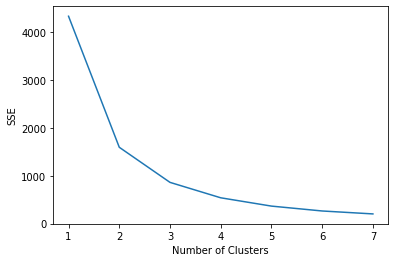

In [30]:
sse={}
df_frequency = customers_scaled[['Frequency']].values
for k in range(1,8):
    freq_model = cluster.KMeans(n_clusters=k, random_state=3)
    freq_model.fit_predict(df_frequency)
    sse[k] = freq_model.inertia_
    
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

#### Silhouette Score

In [31]:
for k in [3,4,5]:
    freq_kmeans= cluster.KMeans(n_clusters = k).fit(df_frequency)
    freq_silhouette_avg = silhouette_score(df_frequency, freq_kmeans.labels_)
    print('Silhouette score for %i Clusters: %0.9f' %(k,freq_silhouette_avg))

Silhouette score for 3 Clusters: 0.524631364
Silhouette score for 4 Clusters: 0.522171882
Silhouette score for 5 Clusters: 0.525942294


- 3 clusters has the highest silhouette score, so we woll chose 3 clusters

#### Assigning Clusters

In [32]:
freq_kmeans = cluster.KMeans(n_clusters=3).fit(customers_scaled[['Frequency']].values)
customers_scaled['FrequencyCluster'] = freq_kmeans.labels_
customers_scaled.sample(5)

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster
1170,13931.0,1.104496,0.256983,0.172452,0,0
1680,14633.0,1.328494,-0.542350,-0.580135,0,0
452,12930.0,0.184358,-0.378460,-0.488990,1,0
3240,16764.0,-1.204544,2.316059,0.851015,2,2
1453,14327.0,0.837478,-0.910466,-0.627233,0,1


#### View the Clusters

In [33]:
customers_scaled.groupby(['FrequencyCluster']).agg({'Frequency' : 'mean'}).sort_values(by='Frequency')

,Frequency
FrequencyCluster,
1,-1.283900
0,-0.070145
2,1.160371


#### Order the Clusters

In [34]:
order_cluster('FrequencyCluster', 'Frequency', customers_scaled )

                  Frequency
FrequencyCluster           
0                 -1.283900
1                 -0.070145
2                  1.160371


Frequency cluster numbers are assigned by choosing a higher frequency for the desired higher cluster number. 0-least frequent to 2-very frequent

---

## Monetary

#### Elbow Method

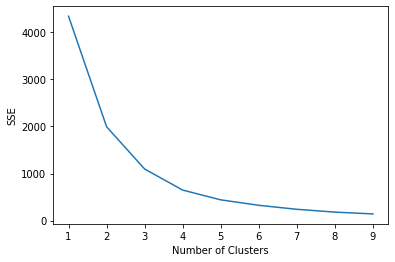

In [35]:
sse={}
df_monetary = customers_scaled[['Monetary']].values
for k in range(1,10):
    mone_model = cluster.KMeans(n_clusters=k, random_state=3)
    mone_model.fit_predict(df_monetary)
    sse[k] = mone_model.inertia_
    
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

#### Silhouette Score

In [36]:
for k in [3,4,5]:
    mone_kmeans = cluster.KMeans(n_clusters=k).fit(df_monetary)
    mone_silhouette_avg = silhouette_score(df_monetary, mone_kmeans.labels_)
    print('Silhouette Score for %i Clusters: %0.4f' %(k,mone_silhouette_avg))

Silhouette Score for 3 Clusters: 0.6101
Silhouette Score for 4 Clusters: 0.5665
Silhouette Score for 5 Clusters: 0.5512


- 3 clusters has the highest silhouette score, so we woll chose 3 clusters

#### Assigning Clusters

In [37]:
mone_kmeans = cluster.KMeans(n_clusters=3).fit(customers_scaled[['Monetary']].values)
customers_scaled['MonetaryCluster'] = mone_kmeans.labels_
customers_scaled.head(5)

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster
0,12346.0,1.543469,-2.568435,6.608337,0,0,1
1,12347.0,-0.343482,1.166124,1.291771,2,2,2
2,12348.0,0.152324,-0.218665,0.459867,1,1,2
3,12349.0,-0.840000,0.435542,0.441642,2,1,2
4,12350.0,1.491995,-0.660525,-0.594668,0,1,0


#### View the Clusters

In [38]:
customers_scaled.groupby(['MonetaryCluster']).agg({'Monetary':'mean'}).sort_values(by='Monetary')

,Monetary
MonetaryCluster,
0,-0.494086
2,0.883160
1,4.875262


#### Order the Clusters

In [39]:
order_cluster('MonetaryCluster', 'Monetary', customers_scaled )

                 Monetary
MonetaryCluster          
0               -0.494086
1                0.883160
2                4.875262


0- Lower monetary value to 2-Higher monetary value

---

# SEGMENTING CUSTOMERS

---

#### Compute Total Score

In [40]:
customers_scaled['TotalScore']= customers_scaled['RecencyCluster'] + customers_scaled['FrequencyCluster'] + customers_scaled['MonetaryCluster']
customers_scaled['SegmentID'] = customers_scaled.apply(lambda x: (str(int(x['RecencyCluster'])) + str(int(x['FrequencyCluster'])) + str(int(x['MonetaryCluster']))), axis=1)
customers_scaled.head(5)

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,TotalScore,SegmentID
0,12346.0,1.543469,-2.568435,6.608337,0,0,2,2,002
1,12347.0,-0.343482,1.166124,1.291771,2,2,1,5,221
2,12348.0,0.152324,-0.218665,0.459867,1,1,1,3,111
3,12349.0,-0.840000,0.435542,0.441642,2,1,1,4,211
4,12350.0,1.491995,-0.660525,-0.594668,0,1,0,1,010


In [41]:
a= pd.DataFrame(customers_scaled['SegmentID'].value_counts())
a.sort_index(ascending=False)

,SegmentID
322,20
321,157
320,12
312,1
311,39
310,84
301,2
300,26
222,32
221,497


In [42]:
customers_scaled['TotalScore'].value_counts()

1    910
2    854
3    732
4    580
5    553
0    500
6    190
7     20
Name: TotalScore, dtype: int64

### Assign Customer Group Names

**High Value Customer**
* High Recency(2,3), Frequency(2) and Monetary Value(2)
- SegmentID : 322,321,312,311,222,221,212

**New Customers**
* High Recency(2,3), Low Frequency(0) and lower Monetary Value(0,1)
- SegmentID : 320,310,302,301,300,220,210,202,201,200

**Low Value Customer**
* Low Recency(0), Frequency(0) and Monetary Value(0)
- SegmentID : 000,001,002,100,101

**Non-Returning Customers**
* Low Recency(0), Higher Frequency(2) and Hihger Monetary Value(2)
- SegmentID : 010,011,012,020,021,022

**Mid Value Customers**
- SegmentID : Rest of the IDs


In [43]:
customers_scaled['Segment'] = 'Mid-Value'
customers_scaled.loc[customers_scaled['SegmentID'].isin(['322','321','312','311','222','221','212']), 'Segment'] = 'High-Value'
customers_scaled.loc[customers_scaled['SegmentID'].isin(['320','310','302','301','300','220','210','202','201','200']), 'Segment'] = 'New_Customer'
customers_scaled.loc[customers_scaled['SegmentID'].isin(['000','001','002','100','101']), 'Segment'] = 'Low-Value'
customers_scaled.loc[customers_scaled['SegmentID'].isin(['010','011','012','020','021','022']), 'Segment'] = 'Non-Returning'
customers_scaled['Segment'].value_counts()


Mid-Value        1160
New_Customer      861
Low-Value         845
High-Value        748
Non-Returning     725
Name: Segment, dtype: int64

---

# VISUALISING THE CLUSTERS

---

In [44]:
customers_scaled.sample(5)

,CustomerID,Recency,Frequency,Monetary,RecencyCluster,FrequencyCluster,MonetaryCluster,TotalScore,SegmentID,Segment
4239,18154.0,-0.273955,-0.506677,-0.509353,1,1,0,2,110,Mid-Value
1740,14713.0,-1.204544,1.683723,0.805203,2,2,1,5,221,High-Value
4174,18066.0,0.152324,-1.039509,-0.617988,1,0,0,1,100,Low-Value
2458,15689.0,-1.866713,-1.113526,-0.717388,3,0,0,3,300,New_Customer
64,12426.0,1.006578,-0.243138,-0.309342,0,1,0,1,010,Non-Returning


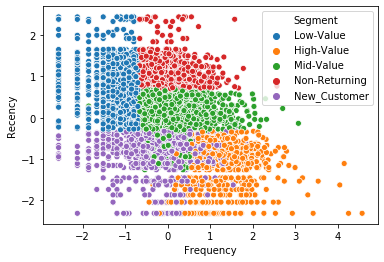

In [45]:
sns.scatterplot(data=customers_scaled, x='Frequency',y='Recency', hue='Segment')

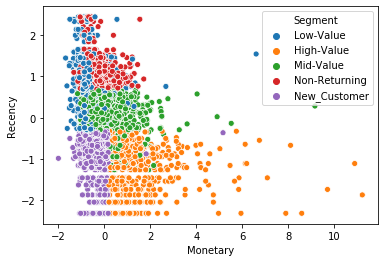

In [46]:
sns.scatterplot(data=customers_scaled, x='Monetary',y='Recency', hue='Segment')

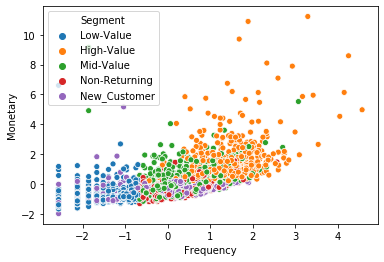

In [47]:
sns.scatterplot(data=customers_scaled, x='Frequency',y='Monetary', hue='Segment')

---

# SEGMENT ANALYSIS

Based on the R/F/M Clusters individually obtained for each of the variables Recency, Frequency and Monetary Value in the RFM table, identify customer characteristics and assign the following Segments

#### New Customers
Customers with High Recency and moderate frequency which may have higher monetary value can be identified as New Customers. They have started visiting the store recently since their recency and frequency are higher, since they are new they havn't yet contributed a lot to the Sales.

#### Non Returning Customers
Customers showing a very low Recency, but higher frequency and monetary value may indicate customers who were regular at some point in the past but are not visiting the stores anymore

#### High Value Customers
Customers that have a high Recency, high Frequency and High Monetary value fall in this category. They are the regular customers who add much to the Sales of the store.

#### Low Value Customers
Customers particularly characterised by lowest Frequency while having a low Recency and low Monetary value fall in this category. This may signify customers who came to the store for few purchases and never returned

#### Mid Value Customers
All the other customers are identified as Mid-Value Customers with moderate values for RFM

---

# CONCLUSION on KMeans

- KMeans Clustering is suited for naturally occuring Circular clusters in 2D visualisation
- Here the clusters are clearly visible but visualy, the demarcation between clusters is observed to be linear

### Takeaways

- Try Other Clustering Algorithms and Compare the results